In [39]:
%matplotlib inline
from binance_download import download_data
from lagged_correlation import *

I will download data for LigthCoin And Ephirium from Binance starting on 1st January 2022. (You can specify the end date optionally).

In [4]:
symbols = ["LTCUSDT", "ETHUSDT"]
interval = '1m'
start_day = '1 Jan, 2022'
api_key = 'your_api_key' 
api_secret = 'your_secret_key'
data = download_data(symbols, start_day, interval, api_key, api_secret)
data.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore,Ticker_Full_Name
0,1640995200000,146.20000000,146.30000000,146.20000000,146.30000000,598.21600000,1640995259999,87472.42510000,64,450.44700000,65868.59730000,0,LTCUSDT
1,1640995260000,146.20000000,146.60000000,146.10000000,146.50000000,898.35900000,1640995319999,131503.80930000,160,570.49600000,83505.71630000,0,LTCUSDT
2,1640995320000,146.50000000,146.50000000,146.40000000,146.50000000,294.72900000,1640995379999,43177.77250000,51,188.71100000,27646.16150000,0,LTCUSDT
3,1640995380000,146.60000000,146.70000000,146.40000000,146.50000000,147.78700000,1640995439999,21660.21780000,49,110.86100000,16249.78400000,0,LTCUSDT
4,1640995440000,146.50000000,146.50000000,146.30000000,146.40000000,110.97600000,1640995499999,16247.20290000,30,32.69300000,4786.58340000,0,LTCUSDT


In [7]:
#convert open time data to datetime
data.loc[:, 'time'] = pd.to_datetime(data['open_time'], unit='ms')

In [8]:
print("Data is from {} to {}, duration: {}\n".format(data.time.min(),
                                                     data.time.max(),
                                                     data.time.max()-data.time.min()))
print(f'Number of unique tickers: {data["Ticker_Full_Name"].nunique()} \n')

data.info()

Data is from 2022-01-01 00:00:00 to 2022-08-26 12:26:00, duration: 237 days 12:26:00

Number of unique tickers: 2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684049 entries, 0 to 684048
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   open_time         684049 non-null  object        
 1   open              684049 non-null  object        
 2   high              684049 non-null  object        
 3   low               684049 non-null  object        
 4   close             684049 non-null  object        
 5   volume            684049 non-null  object        
 6   close_time        684049 non-null  object        
 7   qav               684049 non-null  object        
 8   num_trades        684049 non-null  object        
 9   taker_base_vol    684049 non-null  object        
 10  taker_quote_vol   684049 non-null  object        
 11  ignore            684049 non-null  object        
 12

In [9]:
#convertion of price variables to float
data[['open', 'high', 'low', 'close']] = data[['open', 'high', 'low', 'close']].astype(float)

In [10]:
# make min-max normalization
data.loc[:, 'norm_close'] = data.groupby('Ticker_Full_Name')['close'].\
                                 apply(lambda x: (x-x.min())/(x.max()-x.min())) 

In [11]:
data.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore,Ticker_Full_Name,time,norm_close
0,1640995200000,146.2,146.3,146.2,146.3,598.21600000,1640995259999,87472.42510000,64,450.44700000,65868.59730000,0,LTCUSDT,2022-01-01 00:00:00,0.936340
1,1640995260000,146.2,146.6,146.1,146.5,898.35900000,1640995319999,131503.80930000,160,570.49600000,83505.71630000,0,LTCUSDT,2022-01-01 00:01:00,0.938108
2,1640995320000,146.5,146.5,146.4,146.5,294.72900000,1640995379999,43177.77250000,51,188.71100000,27646.16150000,0,LTCUSDT,2022-01-01 00:02:00,0.938108
3,1640995380000,146.6,146.7,146.4,146.5,147.78700000,1640995439999,21660.21780000,49,110.86100000,16249.78400000,0,LTCUSDT,2022-01-01 00:03:00,0.938108
4,1640995440000,146.5,146.5,146.3,146.4,110.97600000,1640995499999,16247.20290000,30,32.69300000,4786.58340000,0,LTCUSDT,2022-01-01 00:04:00,0.937224


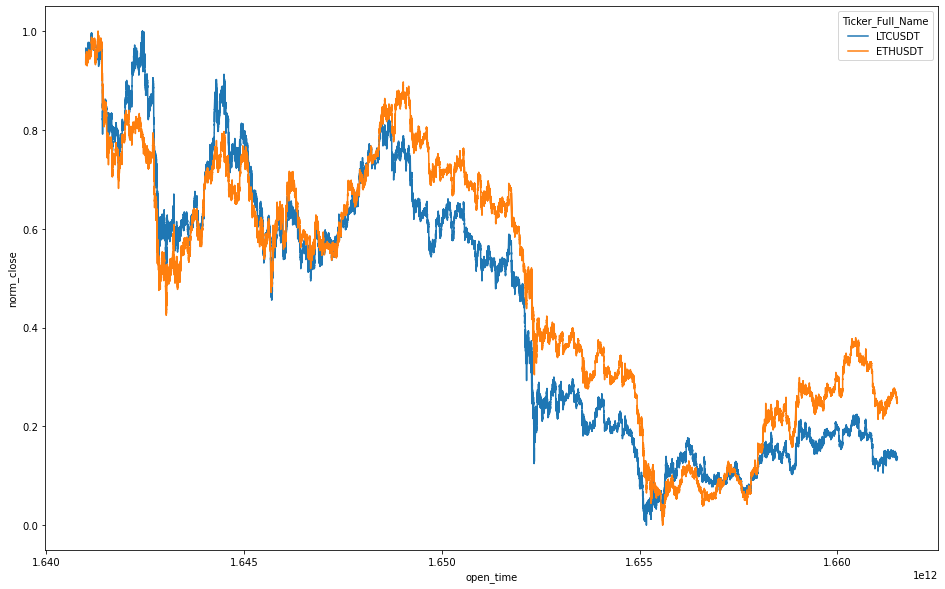

In [12]:
# plot close price for each ticker with min-max normalization
plt.figure( figsize=(16, 10))
sns.lineplot(data=data,
             hue="Ticker_Full_Name",
             x="open_time",
             y='norm_close')
plt.show()

We can see that LiteCoin and Ethereum have almost the same behavior. Nevertheless, we will check them for a lagged correlation. 

Let's transform the data from long to wide format. It would be simpler to use it that way. If there is any NA let's fill it with the last known value.

In [13]:
data_pivot = data.pivot(index='time', 
                        columns='Ticker_Full_Name',
                        values='norm_close')

data_pivot = data_pivot.fillna(method='ffill')
data_pivot = data_pivot.reset_index()
data_pivot.columns.name = None
data_pivot.head()

,time,ETHUSDT,LTCUSDT
0,2022-01-01 00:00:00,0.932023,0.936340
1,2022-01-01 00:01:00,0.934258,0.938108
2,2022-01-01 00:02:00,0.934947,0.938108
3,2022-01-01 00:03:00,0.933935,0.938108
4,2022-01-01 00:04:00,0.933772,0.937224


## Windowed correlation plots

We want to build a correlation plot for several windows.
Here we define a number of windows (no_splits) $20$, and we will search lags (lags_range) in the range of $\pm10$
days with step (lag_step) equal to $30$ minutes

In [31]:
lags_range = 60 * 24 * 10
lag_step = 30
no_splits = 20

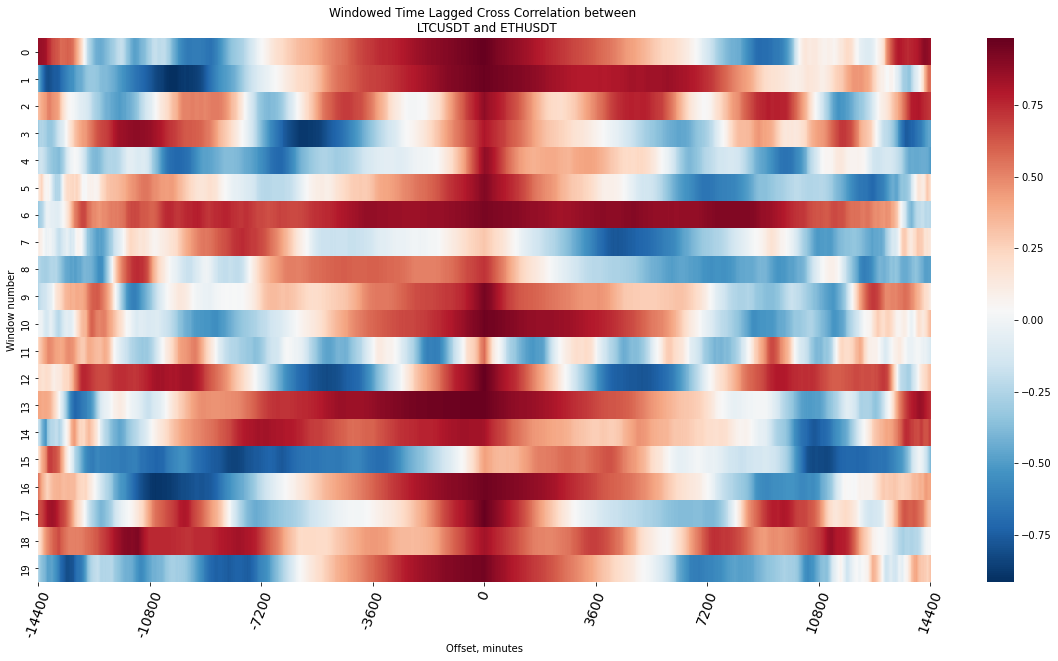

In [32]:
window_lagged_crosscorr(data_pivot.loc[:, symbols[0]],
                        data_pivot.loc[:, symbols[1]],
                        lags_range, lag_step, no_splits)

There is no constant lag between this pair, although they look quite connected at almost all windows with no lag. LiteCoin and Ethereum have some lagged connections on several windows, for example, in the 13th window, there are connections with a lag from 30 minutes up to one day.

## Rolling windowed time lagged correlation plots

Here we will make a rolling window correlation plot for several windows.
We define the length of the window (window_size) as  $2$ days, and we will search lags (lags_range) in range of $\pm2$ days with step (lag_step) equal of $30$ minutes. The window is moved by one day. (arr) is numpy array of lag indexes.

In [24]:
lags_range = 60 * 24
lag_step = 30
window_size = 60 * 24 * 2
step_size = 60 * 24
arr = np.array(range(-int(lags_range), int(lags_range+1), lag_step))

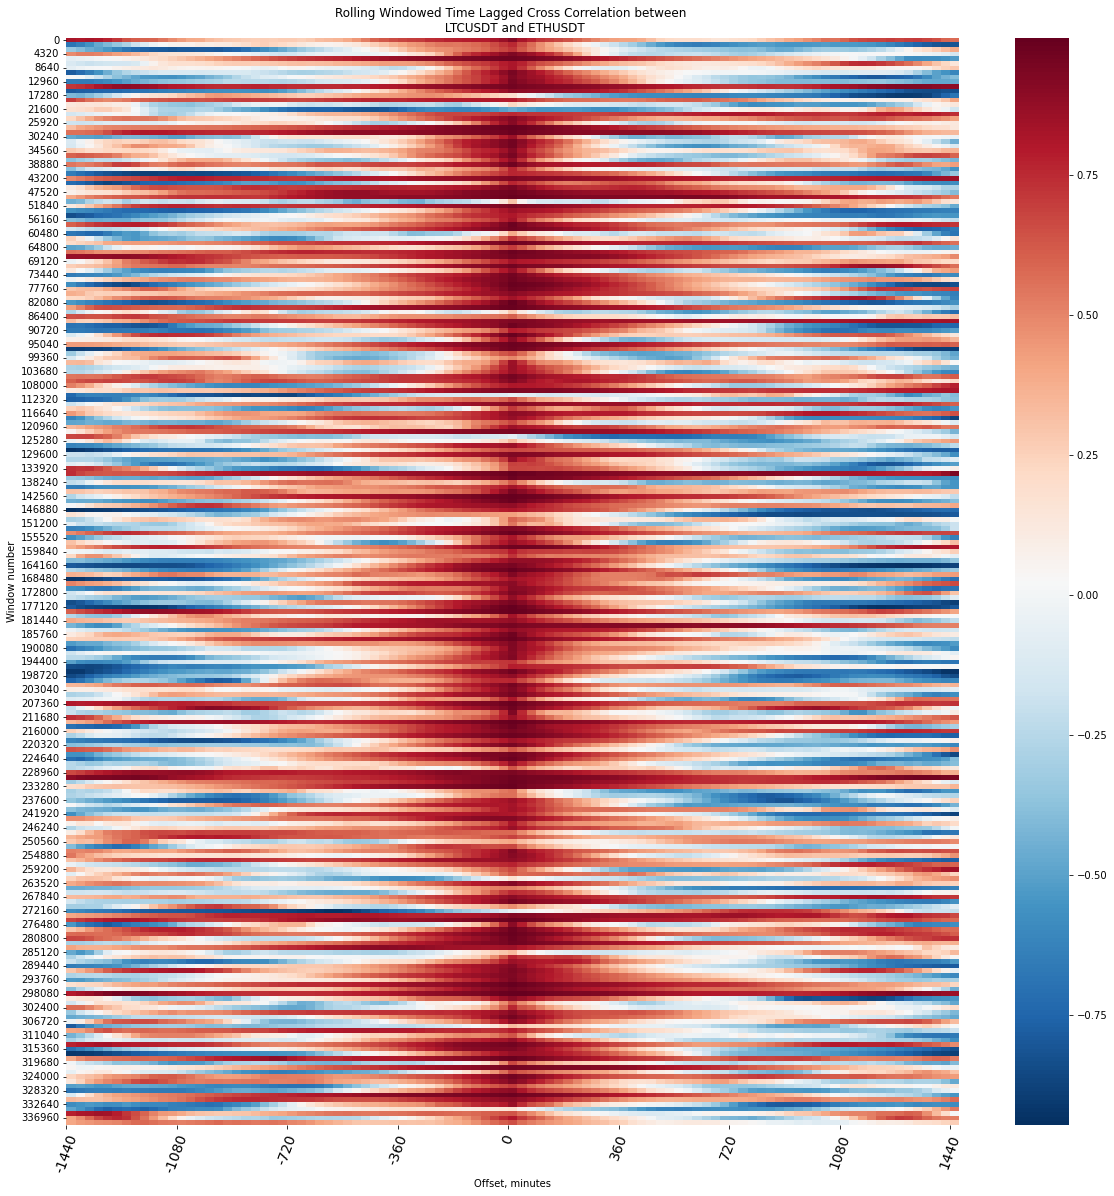

In [25]:
df_0_vs_1 = rolling_window_lagged_crosscorr(
                                    data_pivot.loc[:, symbols[0]],
                                    data_pivot.loc[:,symbols[1]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    return_corr=True)

Here is a more detailed correlation picture for these two coins.

## Top corretations ans lags

In [26]:
threshold_0_vs_1 = best_lags(df_0_vs_1,  arr, threshold=0.95)
threshold_0_vs_1.head()

,window_start,lags
0,5760,"[{'lag': -30, 'corr': 0.9656648057920539}, {'l..."
1,27360,"[{'lag': -30, 'corr': 0.9830467540550705}, {'l..."
2,28800,"[{'lag': -30, 'corr': 0.9708979425214326}, {'l..."
3,47520,"[{'lag': -30, 'corr': 0.9626608477133112}, {'l..."
4,48960,"[{'lag': 30, 'corr': 0.9724087907879846}, {'la..."


In [27]:
most_common_lags(threshold_0_vs_1)

{30: 38,
 -30: 34,
 60: 23,
 -60: 19,
 90: 11,
 -90: 9,
 120: 6,
 -120: 3,
 150: 3,
 1350: 1,
 1320: 1,
 1380: 1,
 1290: 1,
 -1230: 1,
 1410: 1,
 -1260: 1,
 -1290: 1}

The most popular lag is 30 minutes sometimes Litecoin leads sometimes Ethereum. The second frequent lag is 60 minutes.

## Examples of top correlations

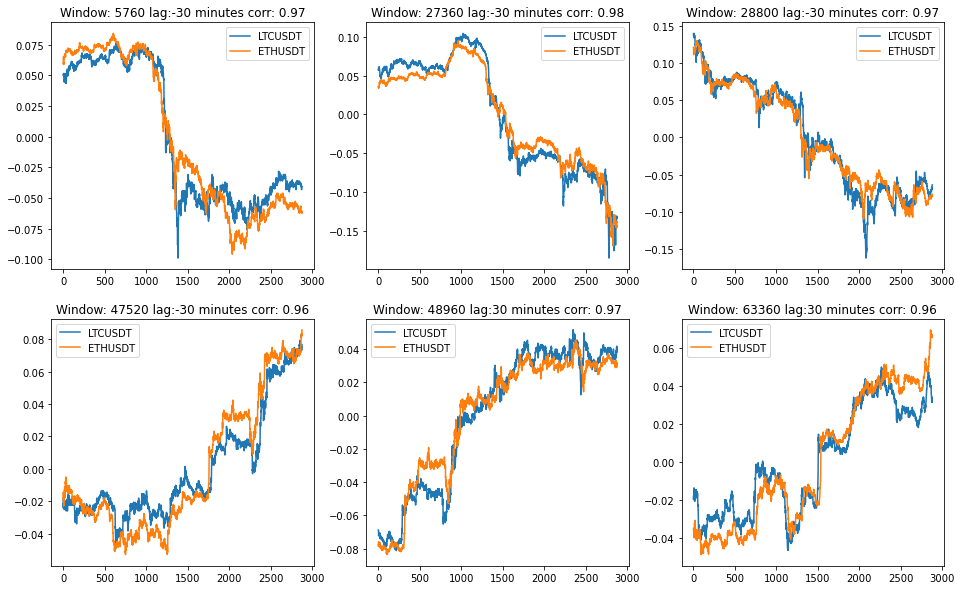

In [28]:
plot_corr_windows(data_pivot.loc[:, symbols[0]],
                  data_pivot.loc[:, symbols[1]],
                  lags_range, lag_step,
                  window_size, step_size,
                  arr)